# Semantic Segmentation of satellite imagery using U-Net

## Step 2: Model building

Adapted from the [code by Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/tree/master/230_landcover_dataset_segmentation). Also see the [tutorial](https://www.youtube.com/watch?v=0W6MKZqSke8)

Dataset: https://www.kaggle.com/datasets/adrianboguszewski/landcoverai?resource=download

This step was done in **Google Colab** for performance reasons. That is why some installs and settings had to be made first.

In [1]:
# Install necessary library
!pip install segmentation_models
!pip install -U tensorflow keras segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00


In [2]:
# Mount Google Drive, where the image files are saved
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# List existing image files (zipped)
!ls /content/gdrive/MyDrive/final_project/data/

landcoverai


In [4]:
# Necessary because of a bug https://github.com/qubvel/segmentation_models/issues/374
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [5]:
import os
import random
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Segmentation Models: using `tf.keras` framework.


In [6]:
# In case the model gets very slow, may be due to a bug in TF2.0. Uncomment this.
# https://github.com/tensorflow/tensorflow/issues/33024
# tf.compat.v1.disable_eager_execution()

# Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch

In [7]:
# Define needed directory paths
dir_root = Path("/content/gdrive/MyDrive/final_project/data/landcoverai/")
dir_train_img = Path(dir_root, "train_images/train/")
dir_train_mask = Path(dir_root, "train_masks/train/")
dir_val_img = Path(dir_root, "val_images/val/")
dir_val_mask = Path(dir_root, "val_masks/val/")
dir_models = Path("/content/gdrive/MyDrive/final_project/data/models/")




# Show how many image files exist
for dir in [dir_train_img, dir_train_mask, dir_val_img, dir_val_mask]:
    files = patch_files = [file for file in dir.iterdir()]
    print(f"{dir} has {len(files)} images.")

/content/gdrive/MyDrive/final_project/data/landcoverai/train_images/train has 2250 images.
/content/gdrive/MyDrive/final_project/data/landcoverai/train_masks/train has 2250 images.
/content/gdrive/MyDrive/final_project/data/landcoverai/val_images/val has 750 images.
/content/gdrive/MyDrive/final_project/data/landcoverai/val_masks/val has 750 images.


In [8]:
classes = {
    0: "Not classified",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Roads",
}

### Visualize random patch alongside its mask

In [9]:
def plot_image_and_mask(image: Path):
    """
    Function to plot an image alongside its mask.
    """
    img = cv2.imread(image.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_path = Path(image.as_posix().replace("/train_images/", "/train_masks/"))
    mask = cv2.imread(mask_path.as_posix())

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img)
    ax1.set_title("Channel 0")

    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    cmap = plt.get_cmap("viridis")

    ax2.imshow(mask[:, :, 1], cmap=cmap, norm=norm)
    ax2.set_title("Mask")

    plt.show()


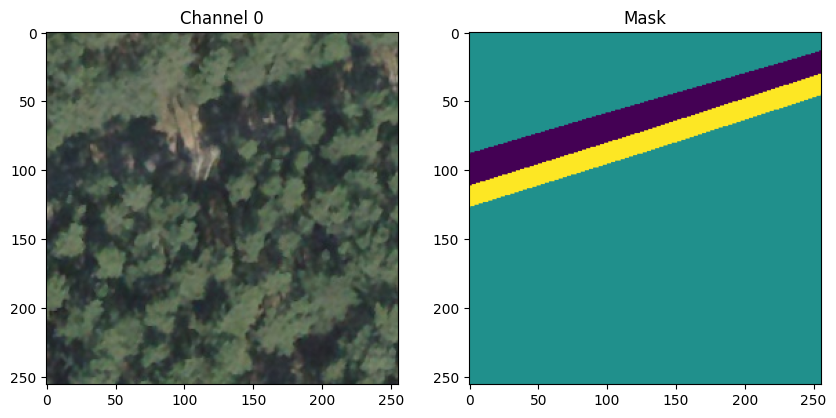

In [10]:
# Get paths of all images
img_files = [file for file in dir_train_img.iterdir()]

# Get random image from all images
img_path = np.random.choice(img_files)

plot_image_and_mask(img_path)


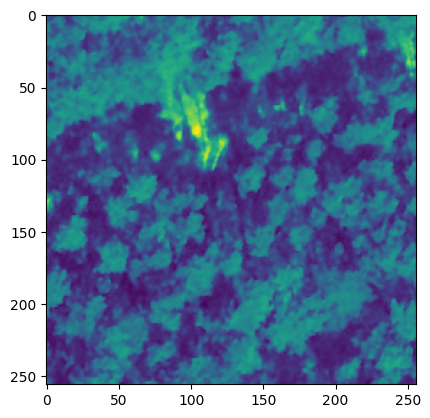

In [11]:
#Quick understanding of the dataset
temp_img = cv2.imread(img_path) #3 channels / spectral bands
plt.imshow(temp_img[:,:,0]) #View each channel...
plt.imshow(temp_img[:,:,1]) #View each channel...
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread(img_path) #3 channels but all same.






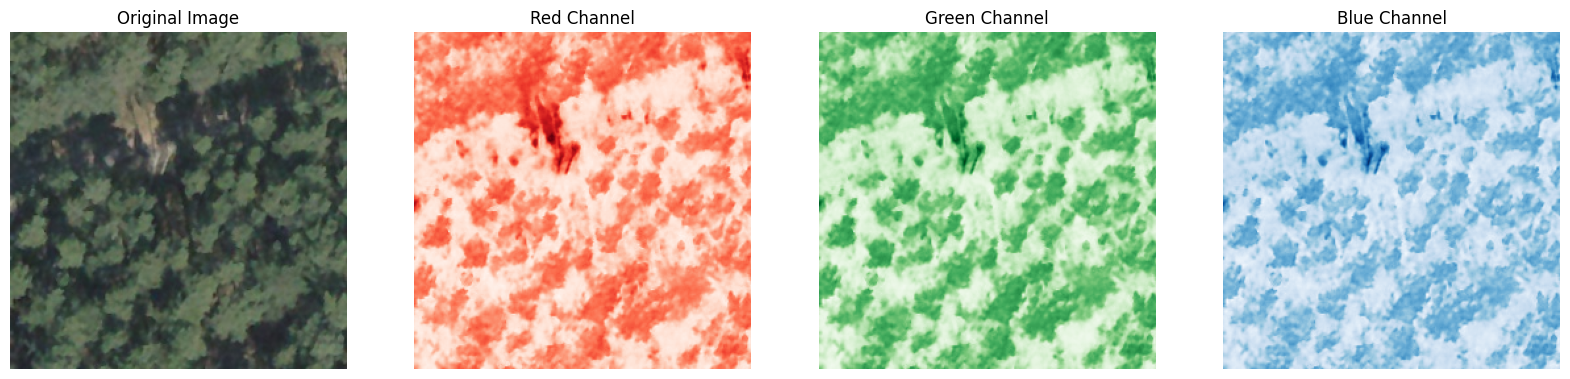

In [12]:


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread(img_path)  # Reads in BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Split the channels
red_channel = img[:, :, 0]  # Red channel
green_channel = img[:, :, 1]  # Green channel
blue_channel = img[:, :, 2]  # Blue channel

# Plot the channels
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img)  # Original image
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(red_channel, cmap="Reds")
axs[1].set_title("Red Channel")
axs[1].axis("off")

axs[2].imshow(green_channel, cmap="Greens")
axs[2].set_title("Green Channel")
axs[2].axis("off")

axs[3].imshow(blue_channel, cmap="Blues")
axs[3].set_title("Blue Channel")
axs[3].axis("off")

plt.show()

In [13]:
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [ 26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 152
 153 154 157 158]  and the counts are:  [   1    1    1    1    3    1    2    8   11   13   26   48   70  108
  152  180  296  415  554  688  823  974 1027 1121 1244 1438 1462 1547
 1525 1445 1449 1397 1379 1438 1315 1275 1239 1160 1183 1080 1066 1006
  978  980  879  936  956  900  913  973  908  943  989  986 1065 1134
 1093 1155 1221 1185 1254 1265 1190 1232 1171 1091 1100 1095 1021  902
  842  785  671  587  557  396  345  259  217  202  130  101  106   65
   66   57

In [14]:
import numpy as np

# Example: Assume temp_mask[:,:,0] contains many unique labels
labels, count = np.unique(temp_mask[:, :, 0], return_counts=True)
print("Original Labels:", labels)

# Create a mapping dictionary to reassign labels to [0,1,2,3,...]
# Ensure all labels in temp_mask are included in the mapping
label_mapping = {old_label: new_label for new_label, old_label in enumerate(labels)} #Changed labels[:4] to labels

# Apply mapping to mask
remapped_mask = np.vectorize(label_mapping.get)(temp_mask[:, :, 0])

# Print new unique labels
new_labels, new_count = np.unique(remapped_mask, return_counts=True)
print("New Labels:", new_labels)
print("New Counts:", new_count)

Original Labels: [ 26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 152
 153 154 157 158]
New Labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108

### Define Generator for images and masks

In [15]:

import segmentation_models as sm

seed = 24
batch_size = 16  # Lower to 8 in case of memory issues
n_classes = len(classes)
encoder_freeze = True

# Use this to preprocess input for transfer learning
BACKBONE = "resnet101"
preprocess_input = sm.get_preprocessing(BACKBONE) # Now sm is defined and this line should work.

In [16]:
print(n_classes)

5


In [17]:
def preprocess_data(img, mask, num_class):
    """
    Function to perform additional preprocessing after datagen.
    """
    scaler = MinMaxScaler()

    # Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

    # Preprocess based on the pretrained backbone
    img = preprocess_input(img)

    # Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img, mask)


In [18]:


def trainGenerator(train_img_path, train_mask_path, num_class):
    """
    Function to define the generator.
    We are not doing any zoom to make sure mask values are not interpolated.
    It is important to keep pixel values in mask as 0, 1, 2, 3, ...
    """
    img_data_gen_args = dict(
        horizontal_flip=True, vertical_flip=True, fill_mode="reflect"
    )

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        str(train_img_path),
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_directory(
        str(train_mask_path),
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
    )

    train_generator = zip(image_generator, mask_generator)

    for img, mask in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [19]:
train_img_gen = trainGenerator(dir_train_img.parent, dir_train_mask.parent, num_class=n_classes)
val_img_gen = trainGenerator(dir_val_img.parent, dir_val_mask.parent, num_class=n_classes)

In [20]:
print(train_img_gen)
print(val_img_gen)

<generator object trainGenerator at 0x7ba1b174e0c0>
<generator object trainGenerator at 0x7ba1b174e5c0>


### Visualize some images to check

Make sure the generator is working and that images and masks are indeed lined up.

Found 2250 images belonging to 1 classes.
Found 2250 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


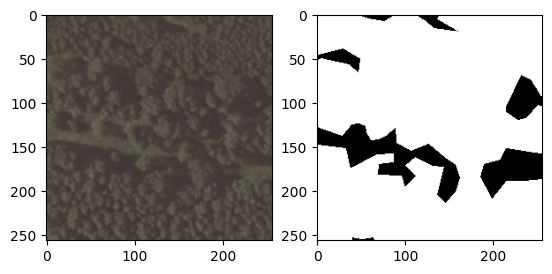

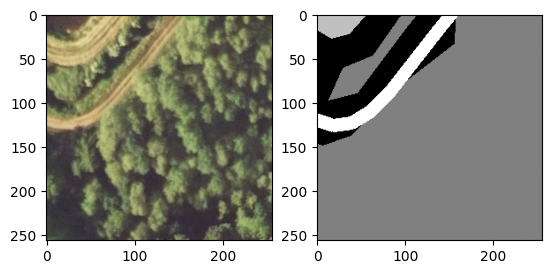

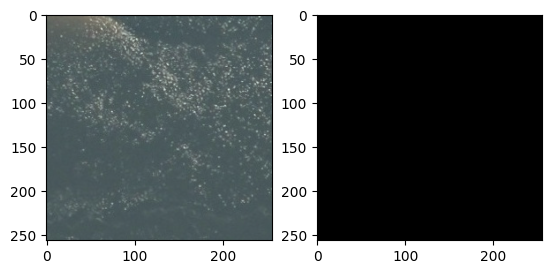

In [21]:
# Load the next batch of batch_size images
x, y = train_img_gen.__next__()

print(x.shape, y.shape)

# Make sure x has 3 layers (RGB)
assert x.shape[3] == 3

# Make sure y has n_classes layers
assert y.shape[3] == n_classes

for i in range(0, 3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()

Found 750 images belonging to 1 classes.
Found 750 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


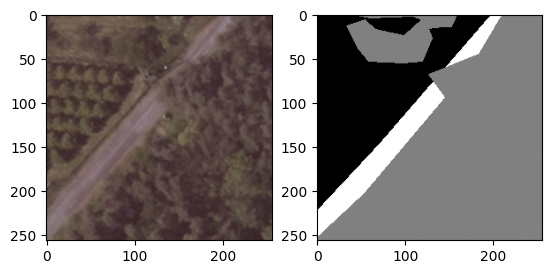

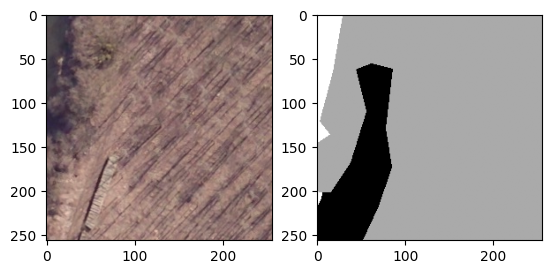

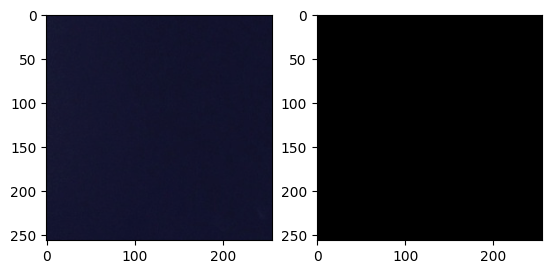

In [22]:
x_val, y_val = val_img_gen.__next__()

print(x_val.shape, y_val.shape)

# Make sure x has 3 layers (RGB)
assert x_val.shape[3] == 3

# Make sure y has n_classes layers
assert y_val.shape[3] == n_classes

for i in range(0, 3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()


### Define the model metrics and load model

In [23]:
num_train_imgs = len([file for file in dir_train_img.iterdir() if file.is_file()])
num_val_images = len([file for file in dir_val_img.iterdir() if file.is_file()])

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH = x.shape[2]
IMG_CHANNELS = x.shape[3]

EPOCHS = 100

In [24]:
print(num_train_imgs)
print(num_val_images)
print(steps_per_epoch)
print(val_steps_per_epoch)

2250
750
140
46


### Use transfer learning using pretrained encoder in the U-Net

We use ***Intersection over Union (IoU)*** as evaluation metric (see [here](https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1)). is used when calculating Mean average precision (mAP). It is a number from 0 to 1 that specifies the amount of overlap between the predicted and ground truth bounding box:

- an IoU of 0 means that there is no overlap between the boxes
- an IoU of 1 means that the union of the boxes is the same as their overlap indicating that they are completely overlapping

In [28]:
# Define the model
model = sm.Unet(
    BACKBONE,
    encoder_weights="imagenet",
    encoder_freeze=encoder_freeze,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    classes=len(classes),
    activation="softmax",
)
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import tensorflow as  tf


def custom_iou_score(gt, pr, **kwargs):


    # Cast to float32 using Keras backend
    gt = tf.keras.backend.cast(gt, dtype='float32')
    pr = tf.keras.backend.cast(pr, dtype='float32')
    return sm.metrics.iou_score(gt, pr, **kwargs)


model.compile(
    "Adam",
    loss=sm.losses.categorical_focal_jaccard_loss,
    metrics=[custom_iou_score],
)

# Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

print(model.summary())
print(model.input_shape)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, 256, 256, 3)    │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_35         │ (None, 262, 262, 3)    │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d_35[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, 128, 128, 64)   │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, 128, 128, 64)   │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_36         │ (None, 130, 130, 64)   │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, 64, 64, 64)     │              0 │ zero_padding2d_36[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, 64, 64, 64)     │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, 64, 64, 64)     │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, 64, 64, 64)     │          4,096 │ stage1_unit1_relu1[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, 64, 64, 64)     │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, 64, 64, 64)     │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_37         │ (None, 66, 66, 64)     │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv2        │ (None, 64, 64, 64)     │         36,864 │ zero_padding2d_37[0][… │
│ (Conv2D)             

 Total params: 51,606,046 (196.86 MB)

 Trainable params: 9,111,448 (34.76 MB)

 Non-trainable params: 42,494,598 (162.10 MB)

None
(None, 256, 256, 3)


In [29]:
from keras.callbacks import EarlyStopping

stop_early = EarlyStopping(
    monitor="val_iou_score", patience=7, verbose=1, mode='max'
)

In [30]:
# Fit the model
history = model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=stop_early,
)

freeze = "freeze" if encoder_freeze else "nofreeze"

file_model = Path(
    dir_models, f"landcover_{BACKBONE}_{EPOCHS}_epochs_batch{batch_size}_{freeze}.hdf5"
)
model.save(file_model)

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1114s 7s/step - custom_iou_score: 0.3548 - loss: 0.6798 - val_custom_iou_score: 0.0758 - val_loss: 1.3509
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 579ms/step - custom_iou_score: 0.5549 - loss: 0.4806 - val_custom_iou_score: 0.0743 - val_loss: 1.3844
Epoch 3/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 587ms/step - custom_iou_score: 0.5923 - loss: 0.4393 - val_custom_iou_score: 0.0739 - val_loss: 1.4063
Epoch 4/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 586ms/step - custom_iou_score: 0.6270 - loss: 0.4026 - val_custom_iou_score: 0.0735 - val_loss: 1.2647
Epoch 5/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 586ms/step - custom_iou_score: 0.6403 - loss: 0.3868 - val_custom_iou_score: 0.1331 - val_loss: 1.1309
Epoch 6/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 541ms/step - custom_iou_score: 0.6553 - loss: 0.3700 - val_custom_iou_score: 0.2267 - val_loss: 0.9265
Epoch 7/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 571ms/step - custom_iou_score: 0.6053 - loss: 0.4316 - val_custom_iou_score: 0.5018 - val_loss: 0.5550
Epoch 8/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 77s 549ms/step - custom_iou_score: 0.6713 - loss: 0.3554 - val_custom_iou_score: 0.5124 - val_loss: 0.5445
Epoch 9/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 564ms/step - custom_iou_score: 0.6253 - loss: 0.4100 - val_custom_iou_score: 0.6519 - val_loss: 0.3740
Epoch 10/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 542ms/step - custom_iou_score: 0.6829 - loss: 0.3419 - val_custom_iou_score: 0.5989 - val_loss: 0.4435
Epoch 11/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 77s 548ms/step - custom_iou_score: 0.6283 - loss: 0.4094 - val_custom_iou_score: 0.6253 - val_loss: 0.4147
Epoch 12/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 547ms/step - custom_iou_score: 0.6260 - loss: 0.4124 - val_custom_iou_score: 0.6062 - val_loss: 0.4339
Epoch 13/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 547ms/step - custom_iou_score: 0.6211 - loss: 0.4149 - val_custom_iou_score: 0.6149 - val_loss: 0.4245
Epoch 14/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 539ms/step - custom_iou_score: 0.6246 - loss: 0.4118 - val_custom_iou_score: 0.6189 - val_loss: 0.4184
Epoch 15/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 543ms/step - custom_iou_score: 0.6488 - loss: 0.3838 - val_custom_iou_score: 0.6122 - val_loss: 0.4297
Epoch 16/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 544ms/step - custom_iou_score: 0.6320 - loss: 0.4045 - val_custom_iou_score: 0.6304 - val_loss: 0.4050
Epoch 17/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 540ms/step - custom_iou_score: 0.6363 - loss: 0.3962 - val_custom_iou_score: 0.6506 - val_loss: 0.3874
Epoch 18/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 543ms/step - custom_iou_score: 0.6625 - loss: 0.3701 - val_custom_iou_score: 0.6358 - val_loss: 0.4048
Epoch 19/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 77s 549ms/step - custom_iou_score: 0.6501 - loss: 0.3870 - val_custom_iou_score: 0.6281 - val_loss: 0.4089
Epoch 20/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 563ms/step - custom_iou_score: 0.6207 - loss: 0.4197 - val_custom_iou_score: 0.6832 - val_loss: 0.3432
Epoch 21/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 541ms/step - custom_iou_score: 0.7287 - loss: 0.2910 - val_custom_iou_score: 0.6262 - val_loss: 0.4128
Epoch 22/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 541ms/step - custom_iou_score: 0.6461 - loss: 0.3885 - val_custom_iou_score: 0.6685 - val_loss: 0.3664
Epoch 23/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 546ms/step - custom_iou_score: 0.6673 - loss: 0.3689 - val_custom_iou_score: 0.6553 - val_loss: 0.3821
Epoch 24/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 539ms/step - custom_iou_score: 0.6511 - loss: 0.3843 - val_custom_iou_score: 0.6153 - val_loss: 0.4237
Epoch 25/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 566ms/step - custom_iou_score: 0.6591 - loss: 0.3745 - val_custom_iou_score: 0.7154 - val_loss: 0.3059
Epoch 26/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 83s 591ms/step - custom_iou_score: 0.7397 - loss: 0.2803 - val_custom_iou_score: 0.7092 - val_loss: 0.3144
Epoch 27/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 536ms/step - custom_iou_score: 0.7420 - loss: 0.2768 - val_custom_iou_score: 0.6498 - val_loss: 0.3912
Epoch 28/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 77s 551ms/step - custom_iou_score: 0.6640 - loss: 0.3688 - val_custom_iou_score: 0.6339 - val_loss: 0.4054
Epoch 29/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 78s 557ms/step - custom_iou_score: 0.6634 - loss: 0.3701 - val_custom_iou_score: 0.7142 - val_loss: 0.3072
Epoch 30/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 539ms/step - custom_iou_score: 0.7510 - loss: 0.2691 - val_custom_iou_score: 0.6574 - val_loss: 0.3811
Epoch 31/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 536ms/step - custom_iou_score: 0.6771 - loss: 0.3564 - val_custom_iou_score: 0.6634 - val_loss: 0.3730
Epoch 32/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 546ms/step - custom_iou_score: 0.6666 - loss: 0.3664 - val_custom_iou_score: 0.6616 - val_loss: 0.3742
Epoch 33/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 74s 531ms/step - custom_iou_score: 0.6998 - loss: 0.3307 - val_custom_iou_score: 0.6830 - val_loss: 0.3483
Epoch 34/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 570ms/step - custom_iou_score: 0.6909 - loss: 0.3414 - val_custom_iou_score: 0.7245 - val_loss: 0.2950
Epoch 35/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 536ms/step - custom_iou_score: 0.7663 - loss: 0.2515 - val_custom_iou_score: 0.6786 - val_loss: 0.3568
Epoch 36/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 538ms/step - custom_iou_score: 0.6919 - loss: 0.3399 - val_custom_iou_score: 0.6778 - val_loss: 0.3531
Epoch 37/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 567ms/step - custom_iou_score: 0.7194 - loss: 0.3085 - val_custom_iou_score: 0.7316 - val_loss: 0.2896
Epoch 38/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 590ms/step - custom_iou_score: 0.7697 - loss: 0.2487 - val_custom_iou_score: 0.7403 - val_loss: 0.2799
Epoch 39/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 580ms/step - custom_iou_score: 0.7616 - loss: 0.2570 - val_custom_iou_score: 0.7256 - val_loss: 0.2959
Epoch 40/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 586ms/step - custom_iou_score: 0.7594 - loss: 0.2599 - val_custom_iou_score: 0.7286 - val_loss: 0.2945
Epoch 41/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 587ms/step - custom_iou_score: 0.7685 - loss: 0.2501 - val_custom_iou_score: 0.7183 - val_loss: 0.3056
Epoch 42/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 590ms/step - custom_iou_score: 0.7526 - loss: 0.2668 - val_custom_iou_score: 0.7408 - val_loss: 0.2799
Epoch 43/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 585ms/step - custom_iou_score: 0.7670 - loss: 0.2505 - val_custom_iou_score: 0.7229 - val_loss: 0.3029
Epoch 44/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 74s 532ms/step - custom_iou_score: 0.7756 - loss: 0.2433 - val_custom_iou_score: 0.6894 - val_loss: 0.3456
Epoch 45/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 575ms/step - custom_iou_score: 0.7272 - loss: 0.3002 - val_custom_iou_score: 0.7419 - val_loss: 0.2790
Epoch 46/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 533ms/step - custom_iou_score: 0.7669 - loss: 0.2513 - val_custom_iou_score: 0.6419 - val_loss: 0.3979
Epoch 47/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 571ms/step - custom_iou_score: 0.6959 - loss: 0.3351 - val_custom_iou_score: 0.7352 - val_loss: 0.2855
Epoch 48/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 542ms/step - custom_iou_score: 0.7723 - loss: 0.2466 - val_custom_iou_score: 0.6246 - val_loss: 0.4182
Epoch 49/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 74s 533ms/step - custom_iou_score: 0.7128 - loss: 0.3168 - val_custom_iou_score: 0.6790 - val_loss: 0.3528
Epoch 50/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 571ms/step - custom_iou_score: 0.7210 - loss: 0.3082 - val_custom_iou_score: 0.7344 - val_loss: 0.2863
Epoch 51/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 589ms/step - custom_iou_score: 0.7754 - loss: 0.2432 - val_custom_iou_score: 0.7445 - val_loss: 0.2773
Epoch 52/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 74s 533ms/step - custom_iou_score: 0.7894 - loss: 0.2273 - val_custom_iou_score: 0.6519 - val_loss: 0.3888
Epoch 53/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 568ms/step - custom_iou_score: 0.6934 - loss: 0.3384 - val_custom_iou_score: 0.7439 - val_loss: 0.2769
Epoch 54/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 588ms/step - custom_iou_score: 0.7873 - loss: 0.2289 - val_custom_iou_score: 0.7556 - val_loss: 0.2653
Epoch 55/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 535ms/step - custom_iou_score: 0.7827 - loss: 0.2345 - val_custom_iou_score: 0.6482 - val_loss: 0.3896
Epoch 56/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 568ms/step - custom_iou_score: 0.7229 - loss: 0.3064 - val_custom_iou_score: 0.7538 - val_loss: 0.2689
Epoch 57/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 587ms/step - custom_iou_score: 0.7898 - loss: 0.2272 - val_custom_iou_score: 0.7435 - val_loss: 0.2766
Epoch 58/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 541ms/step - custom_iou_score: 0.7889 - loss: 0.2284 - val_custom_iou_score: 0.6841 - val_loss: 0.3519
Epoch 59/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 565ms/step - custom_iou_score: 0.6985 - loss: 0.3355 - val_custom_iou_score: 0.7023 - val_loss: 0.3219
Epoch 60/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 539ms/step - custom_iou_score: 0.7792 - loss: 0.2388 - val_custom_iou_score: 0.6207 - val_loss: 0.4360
Epoch 61/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 543ms/step - custom_iou_score: 0.6821 - loss: 0.3514 - val_custom_iou_score: 0.6668 - val_loss: 0.3723
Epoch 62/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 78s 561ms/step - custom_iou_score: 0.7150 - loss: 0.3153 - val_custom_iou_score: 0.7369 - val_loss: 0.2844
Epoch 63/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 543ms/step - custom_iou_score: 0.7852 - loss: 0.2315 - val_custom_iou_score: 0.6669 - val_loss: 0.3691
Epoch 64/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 78s 560ms/step - custom_iou_score: 0.6959 - loss: 0.3376 - val_custom_iou_score: 0.7422 - val_loss: 0.2793
Epoch 65/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 83s 591ms/step - custom_iou_score: 0.7933 - loss: 0.2241 - val_custom_iou_score: 0.7338 - val_loss: 0.2871
Epoch 66/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 581ms/step - custom_iou_score: 0.7960 - loss: 0.2195 - val_custom_iou_score: 0.7498 - val_loss: 0.2708
Epoch 67/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 588ms/step - custom_iou_score: 0.7965 - loss: 0.2205 - val_custom_iou_score: 0.7469 - val_loss: 0.2756
Epoch 68/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 584ms/step - custom_iou_score: 0.8008 - loss: 0.2154 - val_custom_iou_score: 0.7370 - val_loss: 0.2847
Epoch 69/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 589ms/step - custom_iou_score: 0.7993 - loss: 0.2169 - val_custom_iou_score: 0.7449 - val_loss: 0.2804
Epoch 70/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 588ms/step - custom_iou_score: 0.7989 - loss: 0.2182 - val_custom_iou_score: 0.7530 - val_loss: 0.2690
Epoch 71/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 582ms/step - custom_iou_score: 0.7970 - loss: 0.2204 - val_custom_iou_score: 0.7480 - val_loss: 0.2732
Epoch 72/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 542ms/step - custom_iou_score: 0.8022 - loss: 0.2136 - val_custom_iou_score: 0.6724 - val_loss: 0.3669
Epoch 73/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 534ms/step - custom_iou_score: 0.7080 - loss: 0.3248 - val_custom_iou_score: 0.6864 - val_loss: 0.3493
Epoch 74/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 541ms/step - custom_iou_score: 0.7076 - loss: 0.3279 - val_custom_iou_score: 0.6849 - val_loss: 0.3497
Epoch 75/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 534ms/step - custom_iou_score: 0.7220 - loss: 0.3083 - val_custom_iou_score: 0.6693 - val_loss: 0.3698
Epoch 76/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 534ms/step - custom_iou_score: 0.7061 - loss: 0.3276 - val_custom_iou_score: 0.6725 - val_loss: 0.3650
Epoch 77/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 541ms/step - custom_iou_score: 0.7123 - loss: 0.3196 - val_custom_iou_score: 0.6578 - val_loss: 0.3810
Epoch 78/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 535ms/step - custom_iou_score: 0.7294 - loss: 0.3004 - val_custom_iou_score: 0.6610 - val_loss: 0.3799
Epoch 79/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 566ms/step - custom_iou_score: 0.7143 - loss: 0.3181 - val_custom_iou_score: 0.7431 - val_loss: 0.2781
Epoch 80/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 539ms/step - custom_iou_score: 0.8154 - loss: 0.2001 - val_custom_iou_score: 0.6784 - val_loss: 0.3597
Epoch 81/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 535ms/step - custom_iou_score: 0.7399 - loss: 0.2877 - val_custom_iou_score: 0.6673 - val_loss: 0.3726
Epoch 82/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 74s 531ms/step - custom_iou_score: 0.7337 - loss: 0.2936 - val_custom_iou_score: 0.6744 - val_loss: 0.3621
Epoch 83/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 541ms/step - custom_iou_score: 0.7133 - loss: 0.3186 - val_custom_iou_score: 0.6803 - val_loss: 0.3551
Epoch 84/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 563ms/step - custom_iou_score: 0.7381 - loss: 0.2895 - val_custom_iou_score: 0.7536 - val_loss: 0.2680
Epoch 85/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 585ms/step - custom_iou_score: 0.8104 - loss: 0.2039 - val_custom_iou_score: 0.7467 - val_loss: 0.2765
Epoch 86/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 538ms/step - custom_iou_score: 0.8180 - loss: 0.1968 - val_custom_iou_score: 0.6916 - val_loss: 0.3418
Epoch 87/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 567ms/step - custom_iou_score: 0.7507 - loss: 0.2759 - val_custom_iou_score: 0.7530 - val_loss: 0.2686
Epoch 88/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 74s 531ms/step - custom_iou_score: 0.8108 - loss: 0.2048 - val_custom_iou_score: 0.6941 - val_loss: 0.3401
Epoch 89/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 571ms/step - custom_iou_score: 0.7574 - loss: 0.2674 - val_custom_iou_score: 0.7455 - val_loss: 0.2774
Epoch 90/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 83s 591ms/step - custom_iou_score: 0.8129 - loss: 0.2019 - val_custom_iou_score: 0.7499 - val_loss: 0.2738
Epoch 91/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 547ms/step - custom_iou_score: 0.8157 - loss: 0.1992 - val_custom_iou_score: 0.6738 - val_loss: 0.3646
Epoch 92/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 76s 542ms/step - custom_iou_score: 0.7237 - loss: 0.3083 - val_custom_iou_score: 0.6896 - val_loss: 0.3445
Epoch 93/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 540ms/step - custom_iou_score: 0.7680 - loss: 0.2534 - val_custom_iou_score: 0.6857 - val_loss: 0.3520
Epoch 94/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 565ms/step - custom_iou_score: 0.7463 - loss: 0.2798 - val_custom_iou_score: 0.7378 - val_loss: 0.2844
Epoch 95/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 537ms/step - custom_iou_score: 0.8084 - loss: 0.2080 - val_custom_iou_score: 0.6564 - val_loss: 0.3838
Epoch 96/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 538ms/step - custom_iou_score: 0.7033 - loss: 0.3336 - val_custom_iou_score: 0.6564 - val_loss: 0.3831
Epoch 97/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 74s 531ms/step - custom_iou_score: 0.7238 - loss: 0.3101 - val_custom_iou_score: 0.6875 - val_loss: 0.3452
Epoch 98/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 540ms/step - custom_iou_score: 0.7537 - loss: 0.2721 - val_custom_iou_score: 0.6864 - val_loss: 0.3506
Epoch 99/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 566ms/step - custom_iou_score: 0.7429 - loss: 0.2830 - val_custom_iou_score: 0.7557 - val_loss: 0.2657
Epoch 100/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 587ms/step - custom_iou_score: 0.8280 - loss: 0.1863 - val_custom_iou_score: 0.7487 - val_loss: 0.2720


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


### Plot training and validation IoU and loss at each epoch

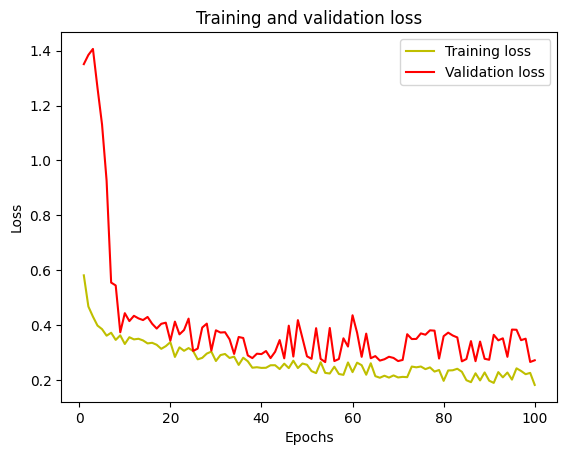

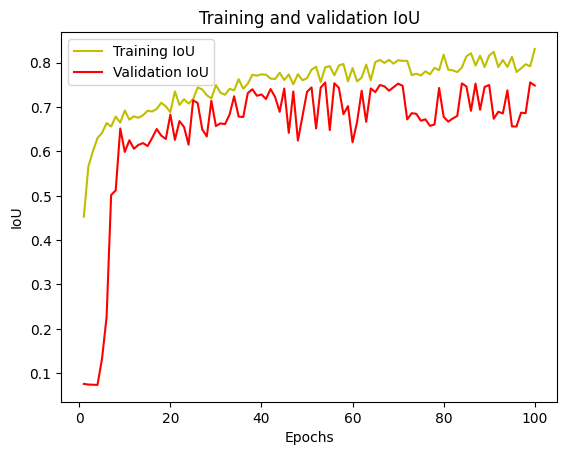

In [31]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["custom_iou_score"]
val_acc = history.history["val_custom_iou_score"]

plt.plot(epochs, acc, "y", label="Training IoU")
plt.plot(epochs, val_acc, "r", label="Validation IoU")
plt.title("Training and validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

### Evaulate model on test data

In [32]:

model = load_model(file_model, compile=False)
model.save(file_model)
# Test generator using validation data.
test_image_batch, test_mask_batch = val_img_gen.__next__()

# Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Mean IoU = 0.732149


## Calculation

- Accuracy is typically used for classification tasks, where the goal is to predict discrete classes. In semantic segmentation, accuracy measures the percentage of pixels that are correctly classified.

- R-squared (R2) is commonly used in regression problems to measure the goodness of fit. It's less relevant in semantic segmentation, which is primarily a classification task.
- Mean Squared Error (MSE) is a regression metric that quantifies the average squared difference between predicted and true values. In semantic segmentation, it can be applied to the pixel-wise probabilities or class labels. However, it might not be the most informative metric for this task.
- Loss is the function used to optimize the model during training. In semantic segmentation, various loss functions can be employed, such as categorical cross-entropy or Dice loss. The loss value reflects the model's overall performance during training.

In [33]:
# Access the loss value from the training history
loss = history.history['loss'][-1]  # Get the last loss value
print("Loss:", loss)

from sklearn.metrics import mean_squared_error

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()  # Or use original probabilities
y_pred_flat = test_pred_batch_argmax.flatten()  # Or use original probabilities

# Calculate MSE
mse = mean_squared_error(y_true_flat, y_pred_flat)
print("Mean Squared Error:", mse)


from sklearn.metrics import accuracy_score

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()
y_pred_flat = test_pred_batch_argmax.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print("Accuracy:", accuracy)


# less Relevant
from sklearn.metrics import r2_score

# Assuming you have continuous predictions (e.g., probabilities)
y_true_flat = test_mask_batch.flatten()  # Use original probabilities
y_pred_flat = test_pred_batch.flatten()  # Use original probabilities

# Calculate R-squared
r2 = r2_score(y_true_flat, y_pred_flat)
print("R-squared:", r2)

Loss: 0.18213431537151337
Mean Squared Error: 0.7105178833007812
Accuracy: 0.8923301696777344
R-squared: 0.7476791371903438


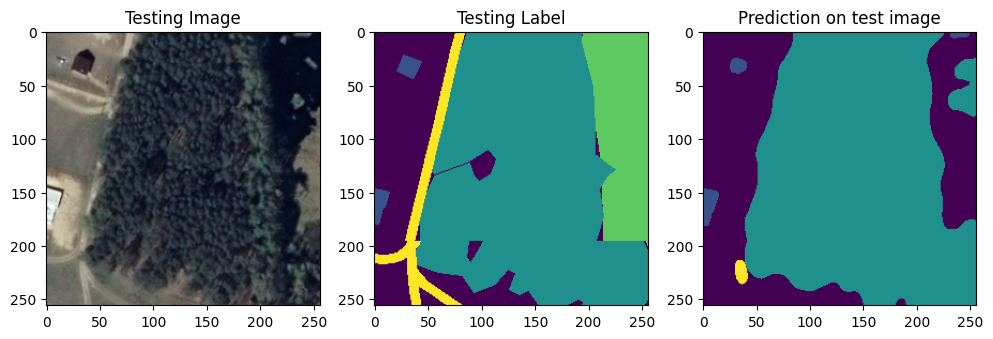

In [34]:
# View a few images, masks and corresponding predictions.
img_num = random.randint(0, test_image_batch.shape[0] - 1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title("Testing Image")
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title("Testing Label")
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()